# GAN + Autoencoders

In this Lab you'll lern how to build GAN networks and apply them to image generation with Autoencoders

## Refs
 - https://github.com/L1aoXingyu/mxnet-tutorial/blob/master/08-AutoEncoder/conv_autoencoder.py
 -



# Task: Pokemons

Lets use some funny example (we're using https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html implementation here.

Pokemon dataset:
https://pokemondb.net/sprites
http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip
https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6

In [12]:
import mxnet as mx
from mxnet import gluon, init, np, npx, nd
from mxnet.gluon import nn
from statistics import mean

import numpy

from matplotlib import pyplot as plt
from tqdm import tqdm

npx.set_np()

In [2]:
pokemon_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset('./data/pokemon')

/var/folders/n0/gr734nl92mn93vzmdrl2_wqm0000gn/T/ipykernel_7043/160289841.py:1: UserWarning: Ignoring ./data/pokemon/.DS_Store, which is not a directory.
  pokemon_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset('./data/pokemon')


In [3]:
# resize each image into 64x64
batch_size = 256

transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)
])

data_loader = gluon.data.DataLoader(
    pokemon_dataset.transform_first(transformer),
    batch_size=batch_size,
    shuffle=True )

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [5]:
def show_one_image(img, title=None):
    """ Plots an image. """

    plt.imshow(img.asnumpy())


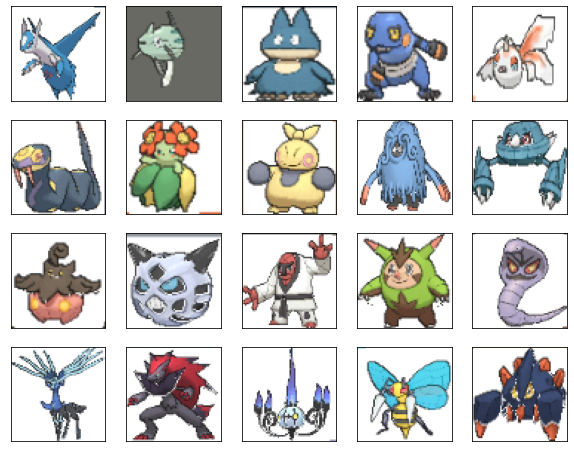

In [6]:
for X, y in data_loader:
    imgs = X[0:20,:,:,:].transpose(0, 2, 3, 1)/2+0.5
    show_images(imgs, num_rows=4, num_cols=5, scale=2)
    break

In [11]:
class autoencoder(nn.HybridBlock):
    def __init__(self):
        super(autoencoder, self).__init__()

        with self.name_scope():
            self.encoder = nn.HybridSequential('encoder_')
            with self.encoder.name_scope():
                # b, 16, 10, 10
                self.encoder.add(
                    nn.Conv2D(
                        16, 3, strides=3, padding=1, activation='relu'))
                self.encoder.add(nn.MaxPool2D(2, 2))  # b, 16, 5, 5
                self.encoder.add(
                    nn.Conv2D(8, 3, strides=2, padding=1,
                                activation='relu'))  # b, 8, 3, 3
                self.encoder.add(nn.MaxPool2D(2, 1))  # b, 8, 2, 2

            self.decoder = nn.HybridSequential('decoder_')
            with self.decoder.name_scope():
                self.decoder.add(
                    nn.Conv2DTranspose(16, 3, strides=2, activation='relu'))
                self.decoder.add(
                    nn.Conv2DTranspose(
                        8, 5, strides=3, padding=1, activation='relu'))
                self.decoder.add(
                    nn.Conv2DTranspose(
                        1, 2, strides=2, padding=1, activation='tanh'))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

In [19]:
def train(model, data_iter, num_epochs, lr, ctx=ctx):

    criterion = gluon.loss.L2Loss()
    optimizer = gluon.Trainer(model.collect_params(), 'adam',
                      {'learning_rate': lr, 'wd': 1e-5})

    history = []

    for epoch in range(num_epochs):
        for data in data_iter:
            img, _ = data
            img = img.as_in_context(ctx)
            batch = img.shape[0]
            # ===================forward=====================
            with mx.autograd.record():
                output = model(img)
                loss = criterion(output, img)
            # ===================backward====================
            loss.backward()
            optimizer.step(batch)
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, nd.mean(loss).asscalar()))
    if epoch % 5 == 0:
        show_one_image(output, f'Epoch: {epoch}')


    return history

In [16]:
model = autoencoder()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier('gaussian'), ctx=ctx)


In [18]:
latent_dim, lr, num_epochs = 100, 0.005, 20
#latent_dim, lr, num_epochs = 100, 0.04, 5
hist = train(model, data_loader, num_epochs, lr)

MXNetError: Traceback (most recent call last):
  File "../src/operator/numpy/np_matrix_op.cc", line 145
MXNetError: Check failed: src.Size() == dst->Size() (3145728 vs. 1048576) : Cannot reshape array of size 3145728 into shape [256,1,64,64]

In [ ]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

In [ ]:
print_history(hist, 'AE Loss')

In [80]:
# Show generated examples
Z = np.random.normal(0, 1, size=(5, latent_dim, 1, 1), ctx=ctx)
Z = Z.as_in_ctx(ctx)
Z.shape

(5, 100, 1, 1)